In [4]:
df = pd.read_csv("../restricted_data/processed.csv")

subjects_without_scans = np.loadtxt("../data/subjects_without_dwi_t1.txt", dtype=int)
df = df[~df.Subject.isin(subjects_without_scans)]


subjects_with_connectomes = np.loadtxt(
    "../data/subjects_with_all_connectomes.txt", dtype=int
)
df = df[df.Subject.isin(subjects_with_connectomes)]
df.sort_values("Subject", inplace=True)

# remove singletons
uniques, counts = np.unique(df.Family_ID, return_counts=True)
singletons = []

for unique, count in zip(uniques, counts):
    if count == 1:
        sub = df[df.Family_ID == unique].Subject.iloc[0]
        singletons.append(sub)

singleton_idx = df.Subject.isin(singletons).values

df = df[~singleton_idx]

male_idx = df.Gender == "M"
female_idx = df.Gender == "F"

df.to_csv("../restricted_data/944subjects.csv", index=False)

In [2]:
import pandas as pd

In [11]:
df = pd.read_csv("../restricted_data/944subjects.csv")

subjects = df.Subject.astype(str).values

In [48]:
from itertools import combinations

from graspologic.embed import *
from joblib import Parallel, delayed
from pkg.data import load_dataset
from pkg.inference import difference_norm

In [10]:
parcellation = "Glasser"

graphs = load_dataset(parcellation=parcellation)
graphs = {key: val for key, val in graphs.items() if key in subjects}

In [51]:
def compute_connectome_distances(subjects, graphs, workers=81):
    """
    subjects : list
    graphs : dict
    """
    subs = [str(s) for s in subjects]

    zg = Parallel(n_jobs=workers)(delayed(select_dimension)(g) for g in graphs.values())
    n_components = int(np.max(zg))

    def worker(G, H, n_components):
        X = AdjacencySpectralEmbed(
            n_components=n_components, check_lcc=False
        ).fit_transform(G)
        Y = AdjacencySpectralEmbed(
            n_components=n_components, check_lcc=False
        ).fit_transform(H)

        res = [difference_norm(X, Y, model) for model in ["exact", "global", "vertex"]]

        return res

    cartesian_prods = list(combinations(subs, 2))

    distances = Parallel(n_jobs=workers)(
        delayed(worker)(graphs[u], graphs[v], n_components) for u, v in cartesian_prods
    )

    distances = np.array(distances)

    return distances

In [52]:
connectome_distances = compute_connectome_distances(subjects, graphs)

In [56]:
np.savez_compressed(
    f"../results/{parcellation}_connectome_distances",
    exact=connectome_distances[:, 0],
    glob=connectome_distances[:, 1],
    vertex=connectome_distances[:, 2],
)

In [57]:
from scipy.spatial.distance import squareform

In [58]:
exact = squareform(connectome_distances[:, 0])

In [59]:
exact.shape

(944, 944)

In [60]:
from pkg.plot import heatmap

In [62]:
exact.min()

0.0

In [63]:
exact.max()

13.539416922471734

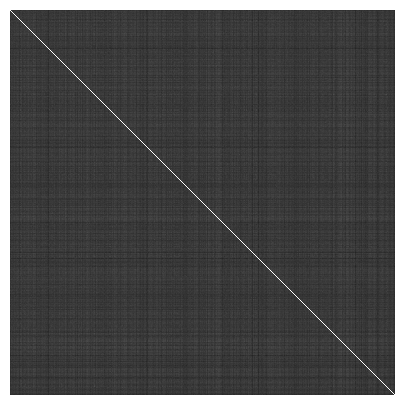

In [61]:
heatmap(exact)

In [71]:
def compute_genome_distances(subjects, df, workers=81):
    """
    subjects : list
    df : pd.DataFrame

    0 = MZ, 1 = NotTwin/DZ, 2 = non-twin sibling, 3 = step-sibling, 4 = unrelated.
    """
    subs = [int(s) for s in subjects]

    cartesian_prods = list(combinations(subs, 2))

    rel_dict = dict(MZ=0, DZ=1, NotTwin=2, Step=3, Unrelated=4)

    def worker(u, v, df):
        subs = df[df.Subject.isin([u, v])]
        fdx1, mdx1, fdx2, mdx2 = subs[["Father_ID", "Mother_ID"]].values.ravel()
        zyg1, zyg2 = subs[["Zygosity"]].values.ravel()

        # below checks if same family
        if (fdx1 == fdx2) and (mdx1 == mdx2):
            if zyg1 == zyg2:
                dist = rel_dict[zyg1]
            elif zyg1 != zyg2:
                dist = rel_dict["NotTwin"]
        elif (fdx1 != fdx2) or (mdx1 != mdx2):
            dist = rel_dict["Step"]
        elif (fdx1 != fdx2) and (mdx1 != mdx2):
            dist = rel_dict["Unrelated"]
        else:  # stepsib
            raise ValueError()
        return dist

    cartesian_prods = list(combinations(subs, 2))

    distances = Parallel(n_jobs=workers)(
        delayed(worker)(u, v, df) for u, v in cartesian_prods
    )

    return np.array(distances)

In [ ]:
genome = compute_genome_distances(subjects, df)